In [307]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import datasets, models, transforms
from dataset import EuroSAT, ImageFiles, random_split
from PIL import Image, ImageChops
import numpy as np

In [241]:
import torchattacks

In [35]:
def load_checkpoint(filepath):
    save = torch.load(filepath, map_location='cpu')
    normalization = save['normalization']
    model = models.resnet50(num_classes=save['model_state']['fc.bias'].numel())
    model.load_state_dict(save['model_state'])
    tr = transforms.Compose([transforms.ToTensor(), transforms.Normalize(**normalization)])
    
    return model, tr

In [36]:
model, tr = load_checkpoint('weights/checkpoint.pt')
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [225]:
classes = ['AnnualCrop','Forest','HerbaceousVegetation','Highway','Industrial','Pasture','PermanentCrop','Residential','River','SeaLake']

In [1]:
def place_patch(img, patch):
    for i in range(img.shape[0]):
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[1]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[2]-1)
        img[i,:,h_offset:h_offset+patch.shape[1],w_offset:w_offset+patch.shape[2]] = patch_forward(patch)
    return img

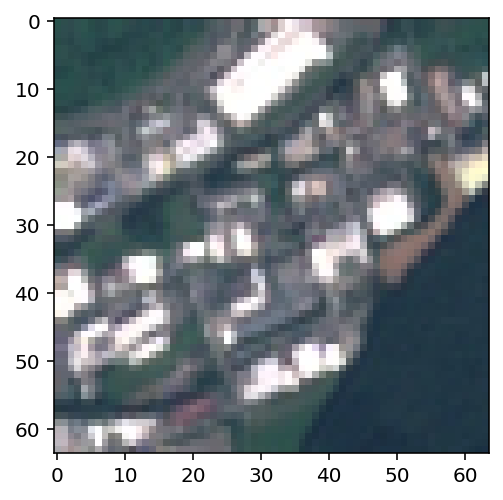

In [328]:
test_image = 'data/2750/Industrial/Industrial_110.jpg'
img = Image.open(test_image)
plt.imshow(img)

In [329]:
model.eval()              # turn the model to evaluate mode
test = tr(img)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = test.to(device, non_blocking=True)
image = image.reshape([1,3,64,64])
with torch.no_grad():     # does not calculate gradient
    class_index = model(image).argmax(1)   #gets the prediction for the image's class
print(classes[class_index])

Industrial


Initial Class: Industrial
tensor([-11.0546, -14.9533,  -8.4912,  -7.3161,   0.8393,  -7.9518,  -7.9577,
         -7.4385,  -1.3471, -10.0014])
Job done, breaking
tensor([-3.3097, -7.7220,  1.7966, -5.8756, -6.1408, -4.5340, -4.4260, -6.2377,
        -3.0432, -4.5629])


'HerbaceousVegetation'

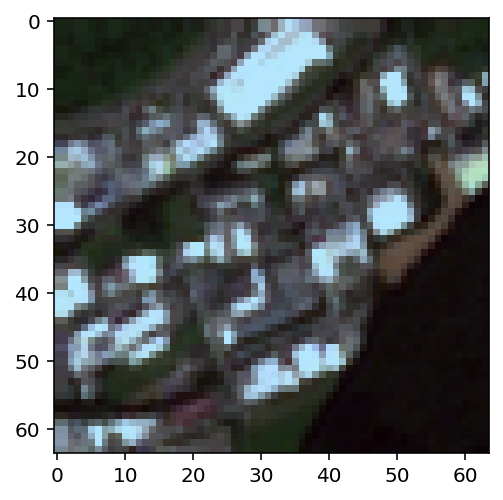

In [305]:
test = tr(img)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = test.to(device, non_blocking=True)
x = image.float().clone()
x.requires_grad_(True)
with torch.no_grad():
    logits = model(x.unsqueeze(0)).squeeze()
    IMX = torch.argmax(logits)
print("Initial Class:",classes[IMX.item()])
print(logits)
    
#lr=.01
lr=.001
while True:
    logits = model(x.unsqueeze(0)).squeeze()
    
    imx = torch.argmax(logits)
    if imx!=IMX: 
        print("Job done, breaking")
        break
    y = logits.clone()
    y[imx] = -99
    loss = logits.max() - y.max() 
    loss.backward()
    
    
    x.data.sub_(lr*x.grad.data)
   # print(loss.item(),logits.max().item(), y.max().item() )
   # print()
    x.grad.data.zero_()
    x.data.sub_(x.data.min())
    x.data.mul_(1/x.data.max())
    
with torch.no_grad():
    print(model(x.unsqueeze(0)).squeeze())
transform = transforms.ToPILImage()
adv_img = transform(x)
plt.imshow(adv_img)
#plt.imshow(x.detach().cpu().numpy().transpose(1,2,0).reshape(64,64,3));
classes[torch.argmax(model(x.unsqueeze(0))).item()]

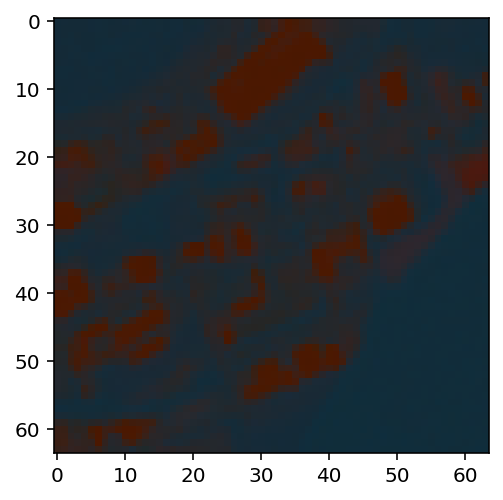

In [270]:
diff = ImageChops.difference(img, adv_img)
plt.imshow(diff)

In [254]:
#atk = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=20)
#atk = torchattacks.BIM(model, eps=8/255, alpha=2/255, steps=100)
atk = torchattacks.FGSM(model, eps=0.001)
#atk = torchattacks.OnePixel(model, pixels=1, inf_batch=10)
#atk = torchattacks.PGDL2(model, eps=1, alpha=0.2, steps=100)
#adv_images = atk(images, labels)

In [271]:
test = tr(img)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image = test.to(device)#, non_blocking=False)
x = image.float().clone()
label = torch.tensor([5])
adv_x = atk(x.reshape([1,3,64,64]),label)

In [272]:
model.eval()
adv_x = adv_x.reshape(3,64,64)
classes[torch.argmax(model(adv_x.unsqueeze(0))).item()]

'PermanentCrop'

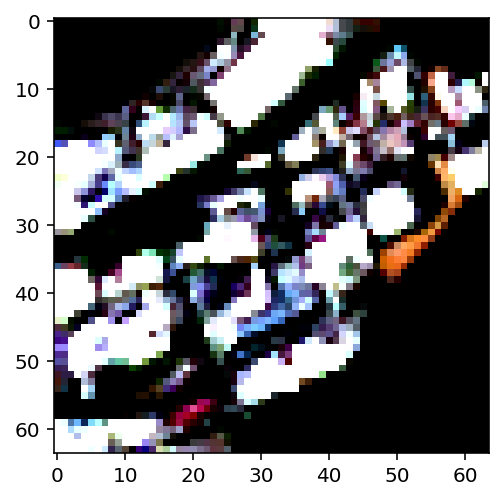

In [273]:
transform = transforms.ToPILImage()
adv_x = transform(adv_x)
plt.imshow(adv_x)